# Assignment 13

## Group Members:
- Eli Weiss
- Omar Hussein
- Julian Ruggiero

# Introduction

A diamond's cut determines how much light the stone reflects. A diamond may have great color, clarity, and size, but if the cut is poor it will be dull and lifeless. Conversely, a diamond with a great cut will emanate sparkle and allure. In this project we will predict the diamond cut based on several categorical explanatory variables that describe different aspects of diamonds.

__Workflow__ <br>
__1)__ Data Profiling <br>
__2)__ Exploratory Data Analysis <br>
__3)__ Data Preparation <br>
__4)__ Prepped Data Review <br>
__5)__ Modeling <br>
__6)__ Select Models <br>
__7)__ Conclusions <br>

# Data Profiling

We will use a Decision Tree, Random Forest, Gradient Boosting Classifier, Stochastic Gradient Descent Classifier, and an XGBoost Classifier to try and predict the cut of a diamond. The data set contains 53940 observations and 10 attributes. More information about the data can be found at: [Link](https://ggplot2.tidyverse.org/reference/diamonds.html) <br>

__1)__  __price__ price in US dollars (`$326`-`$18,823`)
<br>__2)__  __carat__ weight of the diamond (0.2--5.01)
<br>__3)__  __cut__ quality of the cut (Fair, Good, Very Good, Premium, Ideal)
<br>__4)__  __color__ diamond colour, from D (best) to J (worst)
<br>__5)__  __clarity__ a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
<br>__6)__  __x__ length in mm (0--10.74)
<br>__7)__  __y__ width in mm (0--58.9)
<br>__8)__  __z__ depth in mm (0--31.8)
<br>__9)__  __depth__ total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)
<br>__10)__  __table__ width of top of diamond relative to widest point (43--95)

# Exploratory Data Analysis

In [4]:
# importing libraries needed
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import probplot
import numpy as np
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import tree
from yellowbrick.classifier import ConfusionMatrix
from sklearn import metrics
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestClassifier
import os
from io import StringIO
from sklearn.tree import export_graphviz
from IPython.display import Image
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
import pydotplus
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
import xgboost as xgb

# styling matplotlib graphs
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (8,4)

In [5]:
#loading the data set
df = pd.read_csv("https://raw.githubusercontent.com/enwweiss/DAV-6150/master/Project3_Data.csv")

#sanity check
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


Add meaningful column names to x, y and z.

In [6]:
df = df.rename(columns={'x': 'length', 'y': 'width', 'depth': 'depth_percentage', 'z': 'depth'})

In [7]:
#checking data types on raw data and null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   carat             53940 non-null  float64
 1   cut               53940 non-null  object 
 2   color             53940 non-null  object 
 3   clarity           53940 non-null  object 
 4   depth_percentage  53940 non-null  float64
 5   table             53940 non-null  float64
 6   price             53940 non-null  int64  
 7   length            53940 non-null  float64
 8   width             53940 non-null  float64
 9   depth             53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


We can see that we have around 54,000 diamonds and there are no null values in the columns.

In [8]:
#get response counts and percentages
df_response = df.cut.value_counts().to_frame('occurences')
df_response['%_occurences'] = df_response.occurences / df.shape[0]
df_response

,occurences,%_occurences
Ideal,21551,0.399537
Premium,13791,0.255673
Very Good,12082,0.223990
Good,4906,0.090953
Fair,1610,0.029848


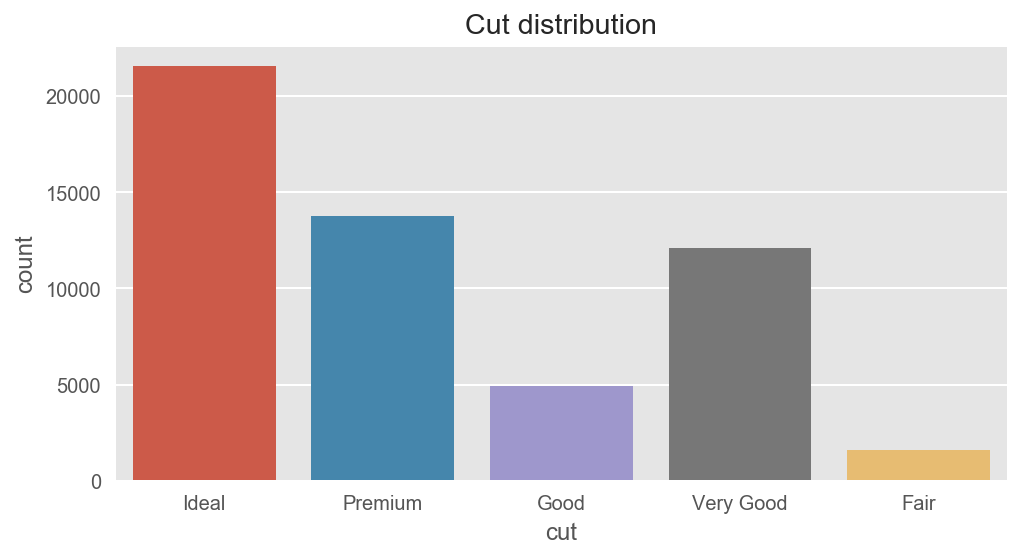

In [9]:
sns.countplot(x = 'cut', data = df).set_title("Cut distribution");

We can see that we have an imbalance response variable with 'Ideal' being the most frequent diamond cut class. We have a null error rate of almost 40%. <br>
Next we will create a list with the categorical attributes and a list numeric attributes. After that we perform EDA on both feature types.

In [10]:
columns = df.columns.to_list()
catergorical = ['color', 'clarity']
numeric = ['carat','depth_percentage', 'table', 'price', 'length', 'width', 'depth']

### Categorical EDA

We create plots of the color and the clarity vs the response. We will provide appropriate order so the 'x' axis will go from the worst class to the best on both cases.

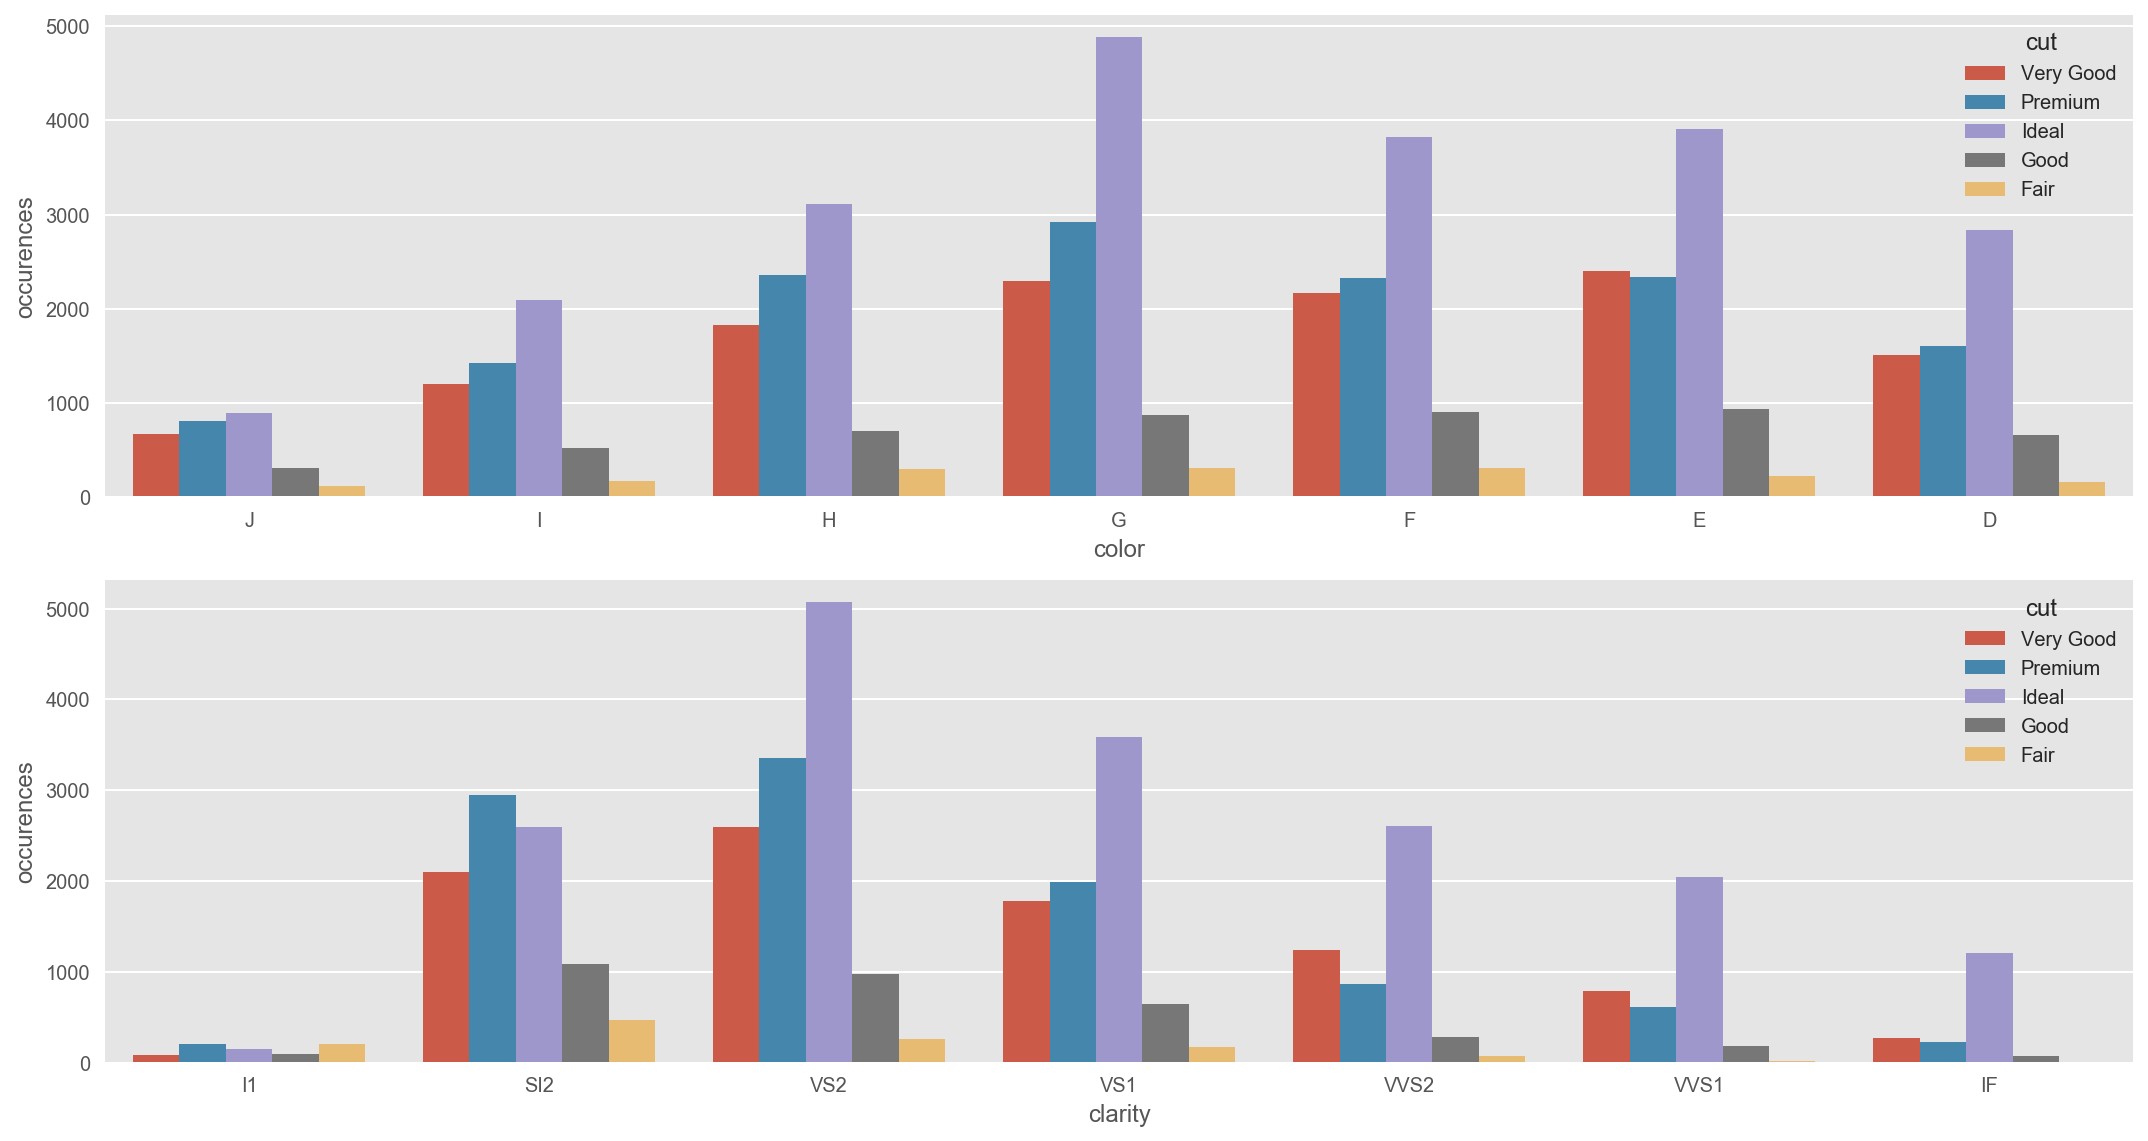

In [11]:
#define a figure to which we will add histogram of each attribute.
plt.figure(figsize=(15,8))

#use an index to identify the spot of the subplot
j = 1

order=[]
order_color=['J','I','H','G','F','E','D'] #D (best) to J (worst)
order_clarity = ['I1','SI2','VS2','VS1','VVS2','VVS1','IF'] # (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))


# Columns
for k in catergorical: #for each numeric column in the dataframe
    if k == 'color':
        order = order_color
    if k == 'clarity':
        order = order_clarity
        
    plt.subplot(2,1,j)
    dt = df.groupby([k,'cut']).size().to_frame('occurences').reset_index().sort_values(by='cut', ascending=False)
    sns.barplot(x=k, y='occurences', hue='cut', data=dt, order=order)
    j = j + 1 #add 1 to go to the next subplot space

#show results
plt.tight_layout()
plt.show();

There seems to be a pattern on both color and clarity with the response. For color, the distribution of 'Very good', 'Premium' and 'Ideal' cuts are evenly distributed for the worst color 'J', while for the rest ‘Ideal’ seems to be the dominant cut. A similar distribute can be found in the ‘Clarity’ attribute.<br><br>
Both predictors look like they will be helpful for predicting our response variable ‘Cut.’

### Numeric EDA

We will plot the numeric attributes to see correlations between each one of them. After this we will seek to identify collinearity if there is any. Then we will incorporate the response after some data cleaning, so we will have an ordinal categorical data to compare to the numeric attributes.

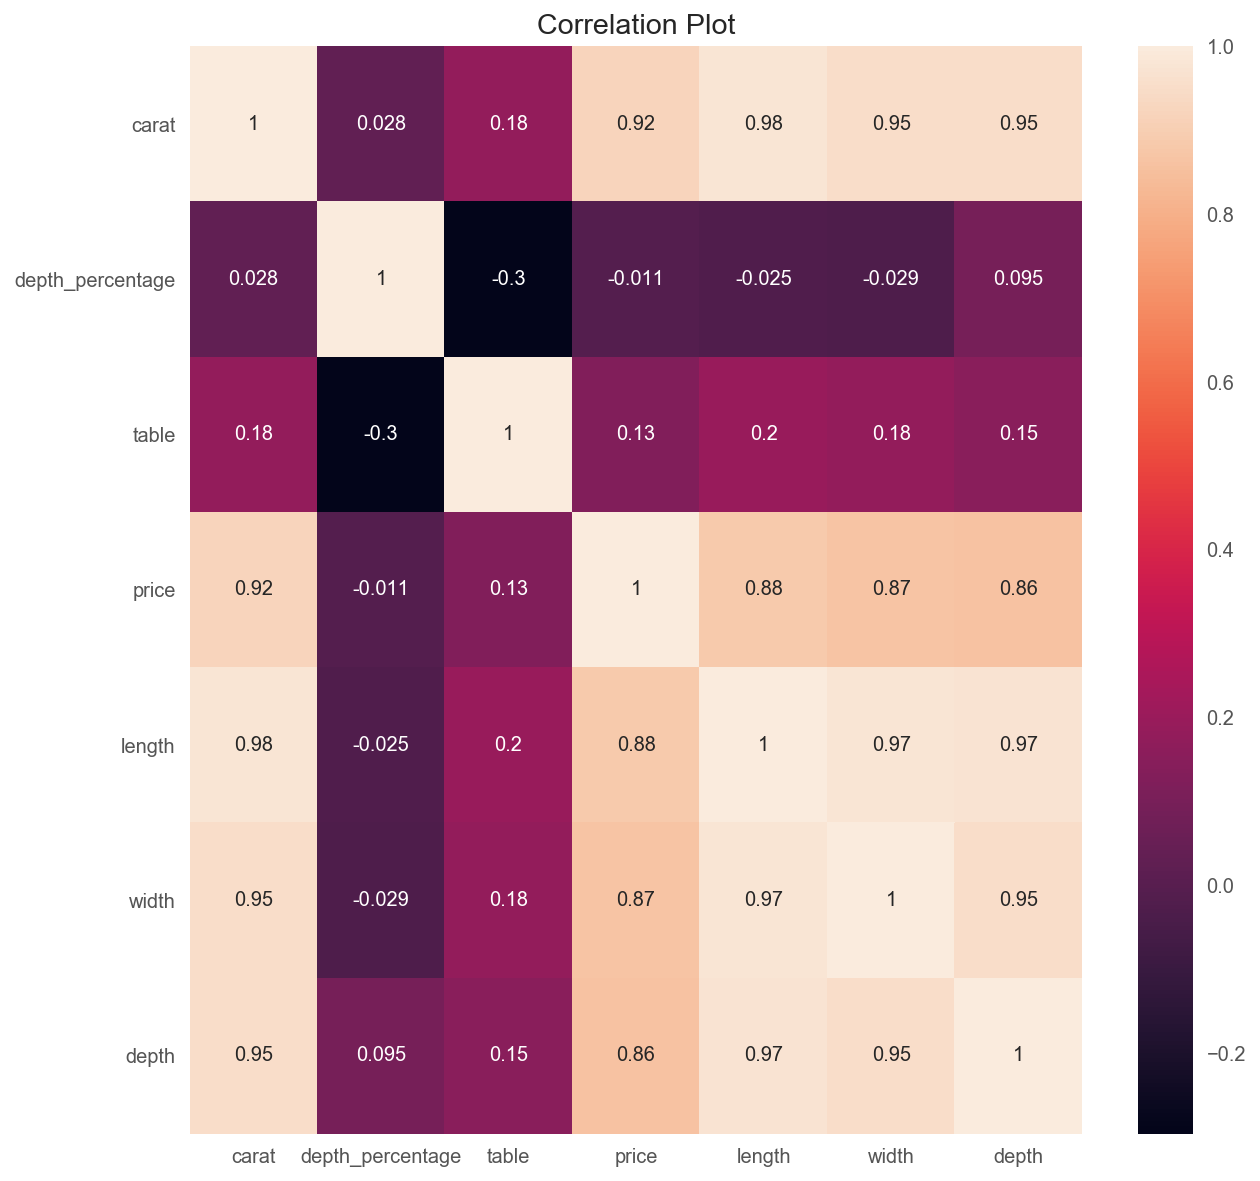

In [12]:
# initial correlation
cor = df.corr()
plt.figure(figsize=(10,10))
plt.title("Correlation Plot")
sns.heatmap(cor,annot=True)
plt.show()

There seems to be strong collinearity between carat and price, length, width and depth so we will include only one of these 4 features in our models.

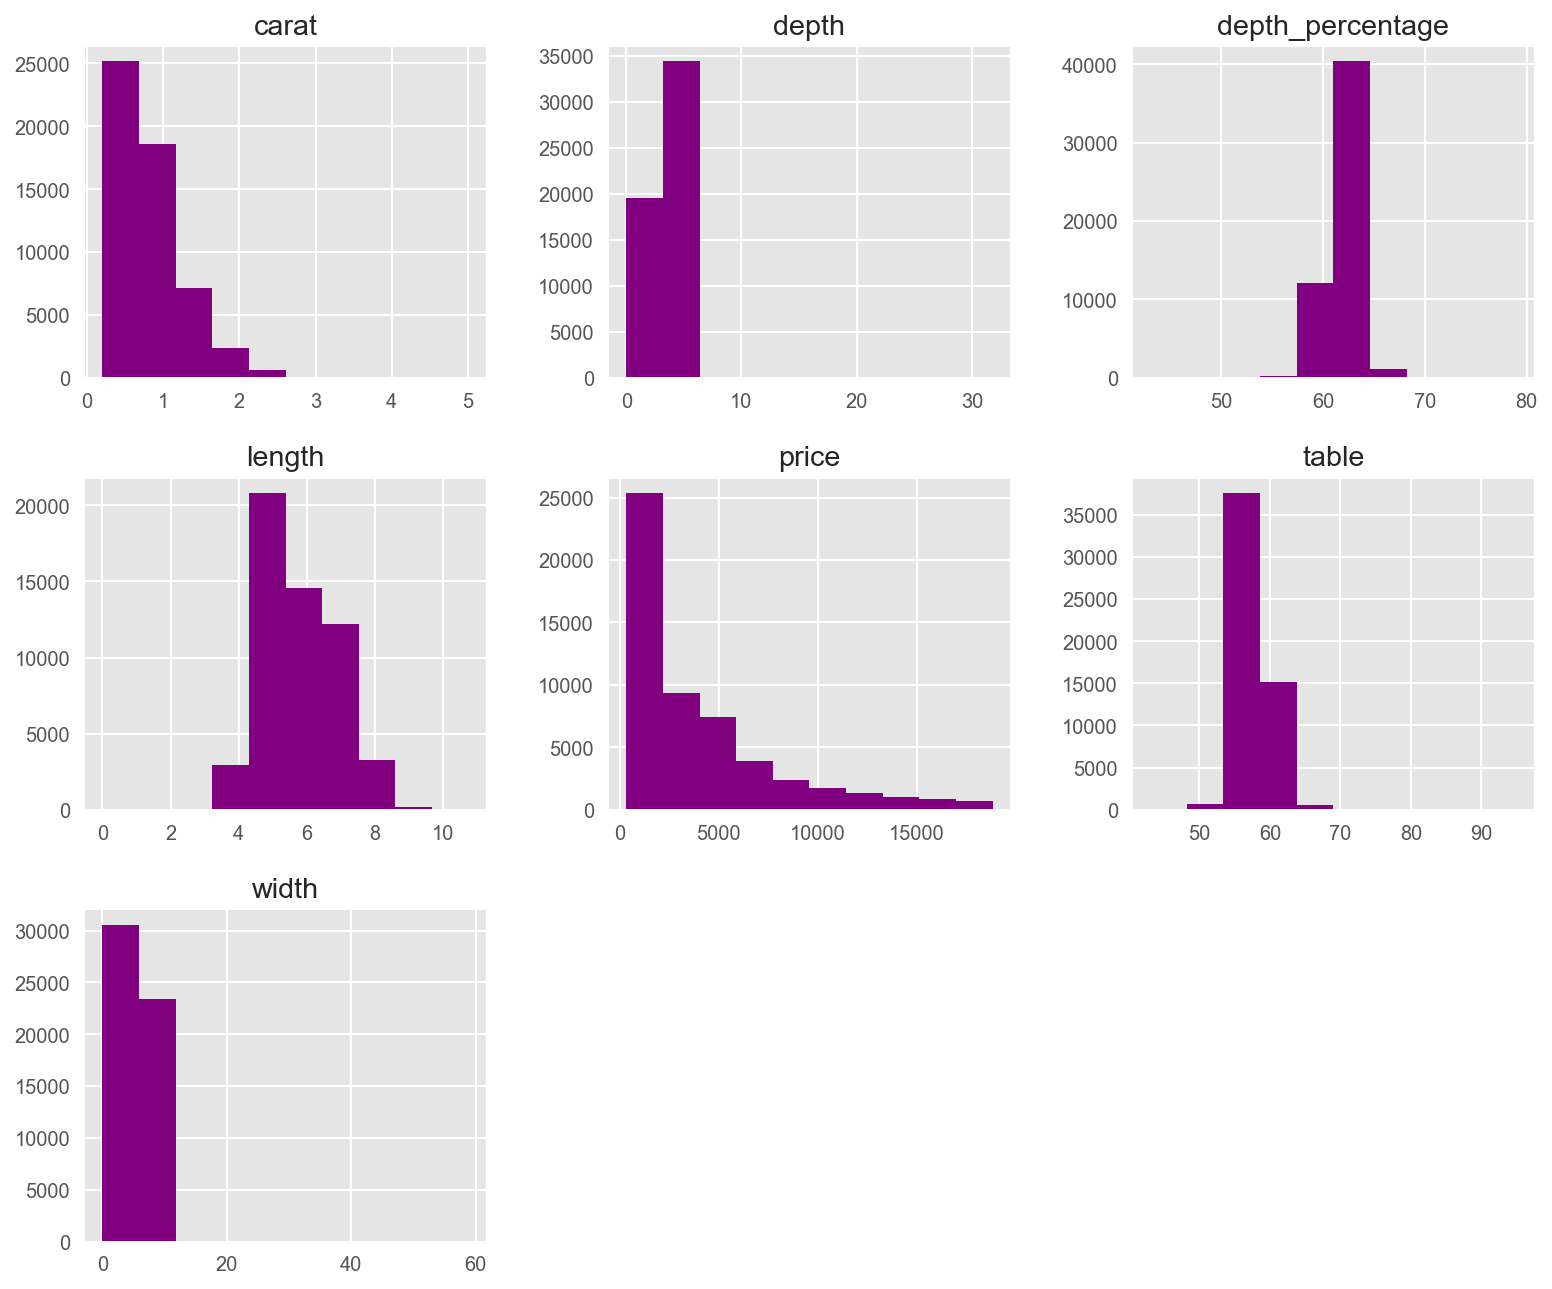

In [13]:
df[numeric].hist(figsize=(13, 11), color='purple');
plt.show();

We see some right skewed data for carat, price and length. Next we identify outliers and plot the numeric attributes vs the response.

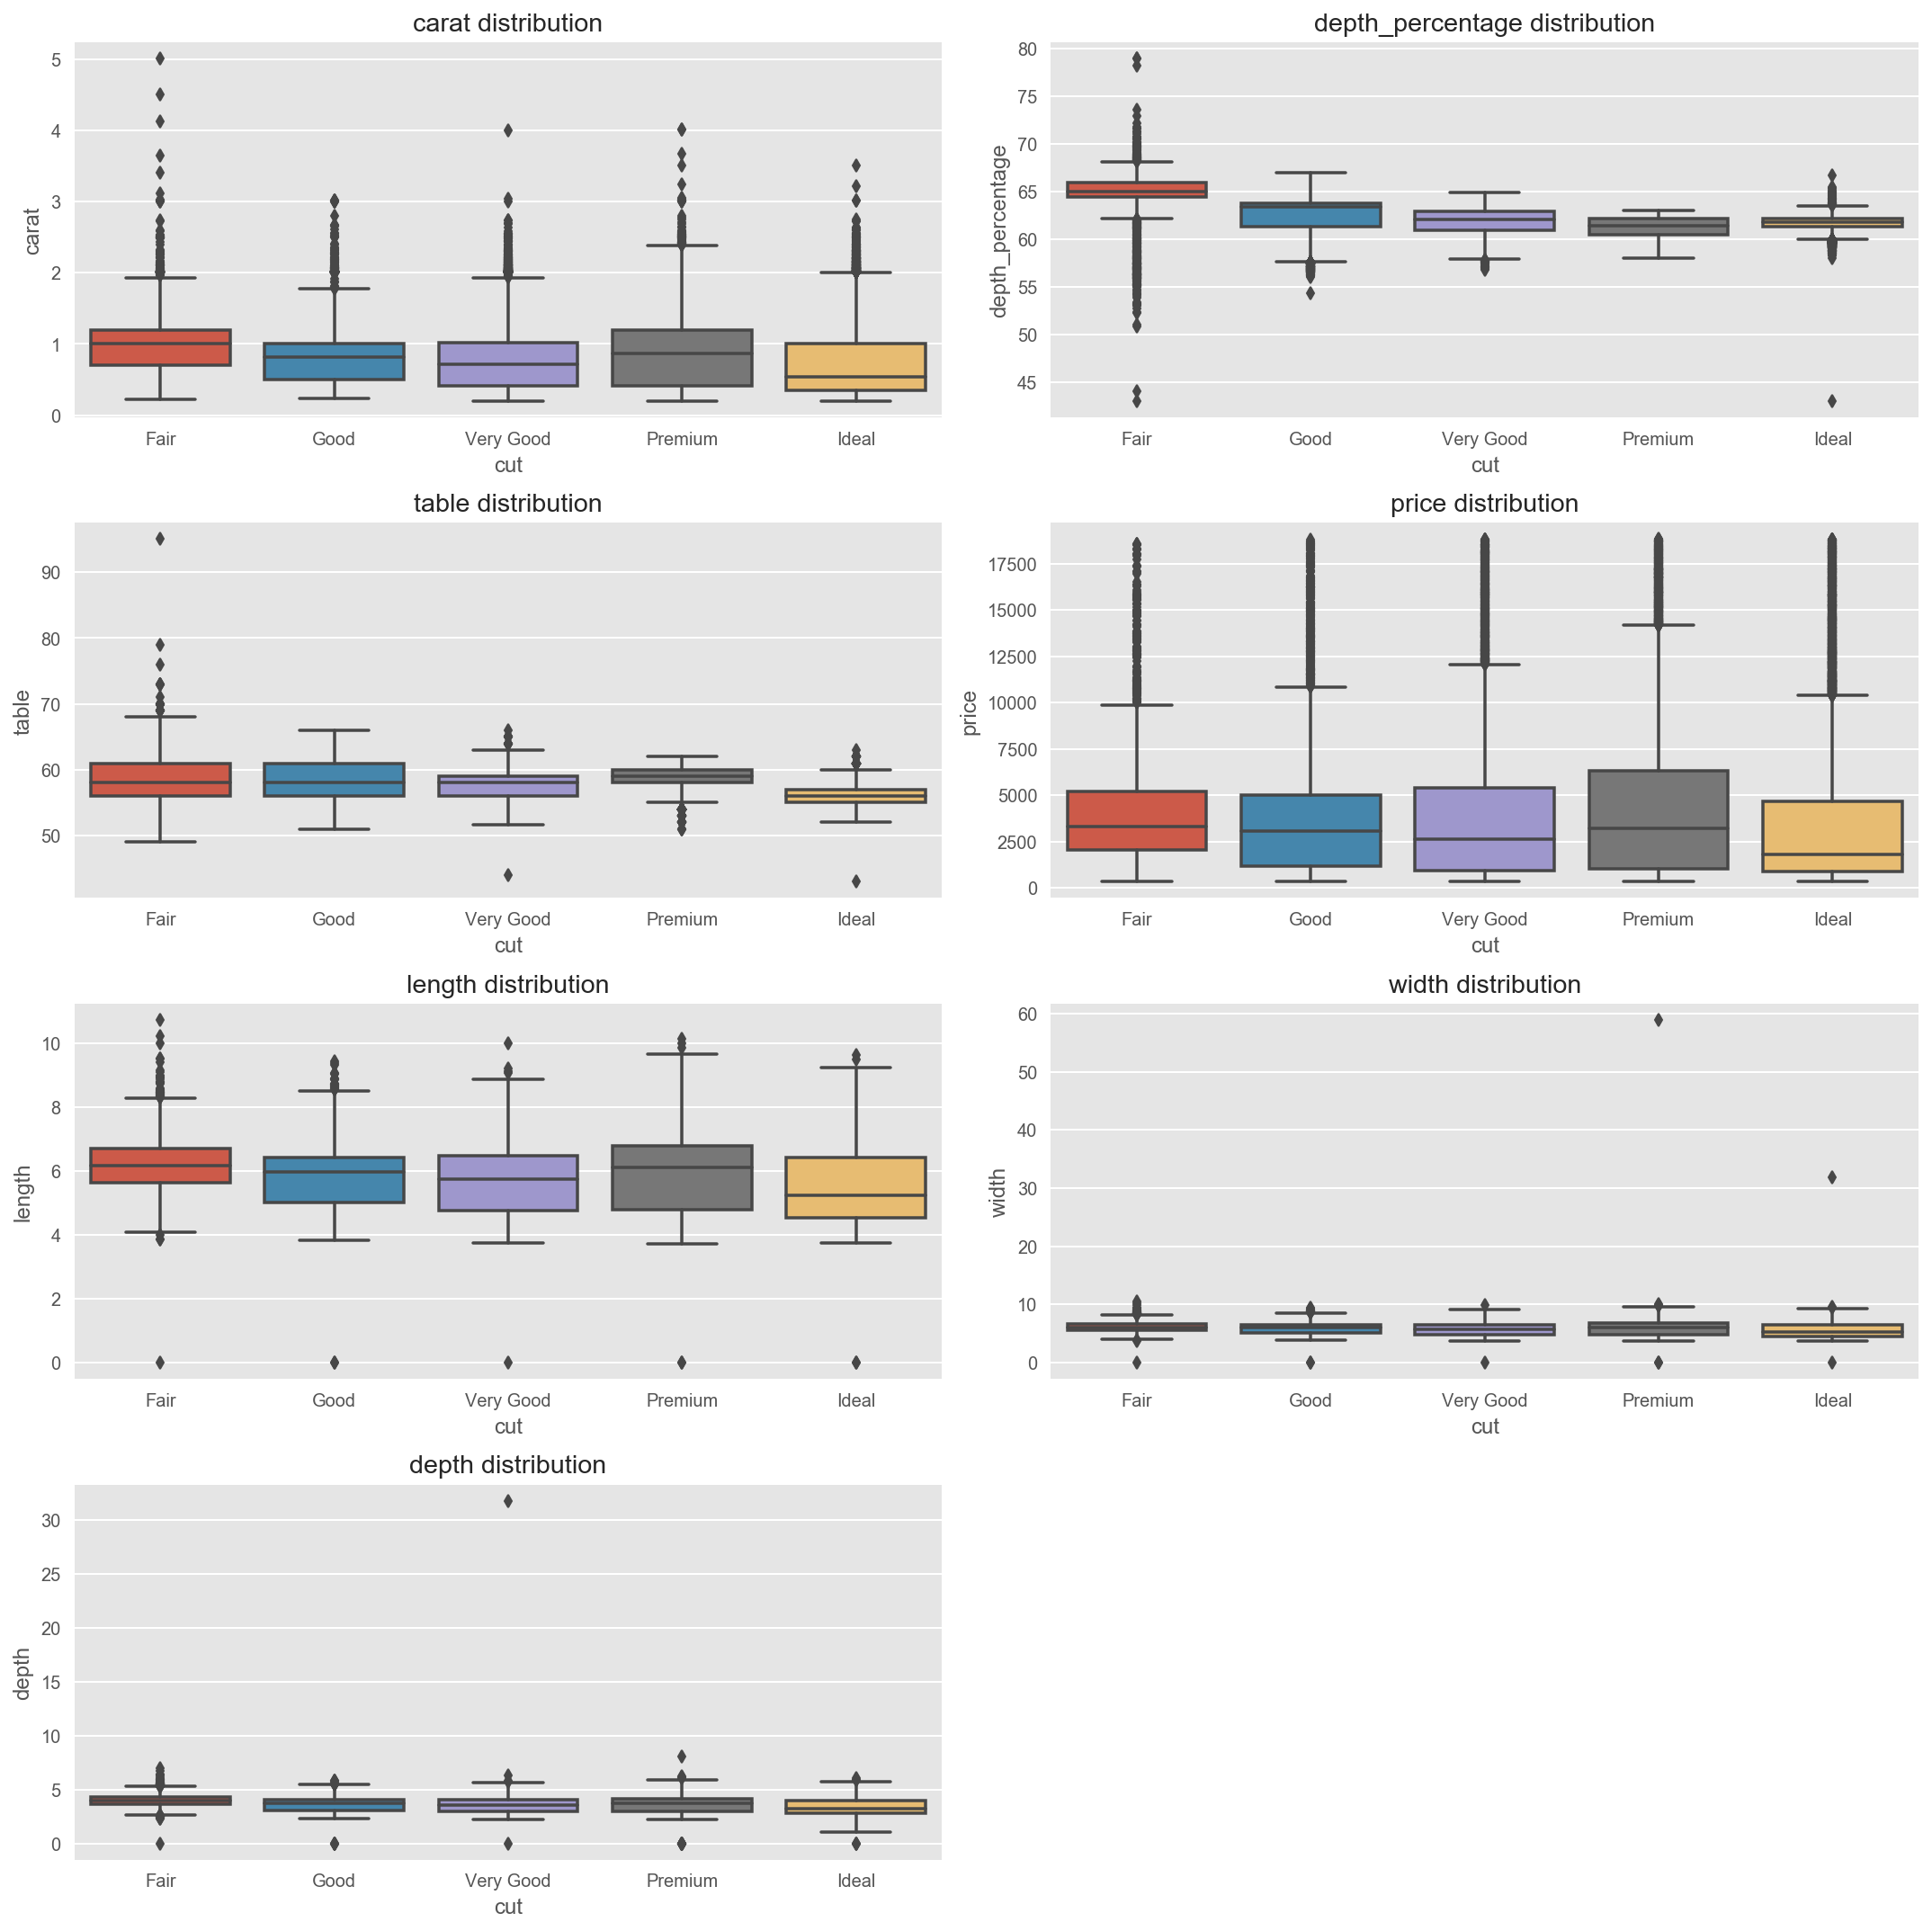

In [14]:
# define a figure to which we will add histogram of each attribute.
plt.figure(figsize=(15,15))

#use an index to identify the spot of the subplot
j = 1

# Columns
for k in numeric: #for each numeric column in the dataframe
    if k == 'length_width_ratio':
        continue
    plt.subplot(4,2,j)
    sns.boxplot(x="cut", y=k, data=df, order=['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'])
    plt.title(k + " distribution");
    j = j + 1 #add 1 to go to the next subplot space

#show results
plt.tight_layout()
plt.show();

We can see that there are potential outliers for table, length, width, and depth. <br>Length, width, and depth all have zero values, which are not valid values for dimensions of diamonds based on our research. <br>Depth will require further investigation since it has a few records with extremely high values.

In addition to issues related to outliers, we see different scales in the features. Price, for example, has values up to 17500, whereas the highest value for Carat is 5. To make sure that our models can predict our response well we will need to transform the data to have similar scales for our attributes.

# Data Preparation

## Excluding invalid records

As mentioned in the EDA we can see several records that would need to be removed. First we delete those who have a zero in either x, y or z.

In [15]:
#checking number of records to delete
print(df[(df.length == 0) | (df.width == 0) | (df.depth == 0)].shape[0])

#excluding where 'x' or 'y' or 'z' = 0
df = df[(df.length != 0) & (df.width != 0) & (df.depth != 0)]

20


In [16]:
#sanity check
df.shape

(53920, 10)

Next we evaluate some extreme values for depth and width to understand if they make sense in the context of our problem.

In [17]:
df[(df.depth > 10) | (df.width > 30)]

,carat,cut,color,clarity,depth_percentage,table,price,length,width,depth
24067,2.00,Premium,H,SI2,58.9,57.0,12210,8.09,58.90,8.06
48410,0.51,Very Good,E,VS1,61.8,54.7,1970,5.12,5.15,31.80
49189,0.51,Ideal,E,VS1,61.8,55.0,2075,5.15,31.80,5.12


We see that for the 1 record with a width of 32 mm has a table value above that number. This is not consistent with our research.<br> We also have 1 record with Width of 59 mm, which is nearly 6 times the diamond length (8 mm) so we believe this record is not plausible either.<br>
Lastly the record with a depth of 31.8 mm is not consistent with the depth_percentage value according to our research. 
Because of the reasons mentioned above we will exclude these three records.

In [18]:
#excluding the 3 records above
df = df[(df.depth < 10) & (df.width < 30)]

In [19]:
#sanity check
df.shape

(53917, 10)

Next we will calculate the total depth percentage based on the formula in the data dictionary (2 * z / (x + y)) to see if it is the same as the actual column values. We will also take the absolute value of the difference with the original column to see if there is a discrepancy between the calculated and original field.

In [20]:
df['perc_real_depth'] = ((2 * df.depth) / (df.length + df.width)) * 100
df['perc_depth_difference'] = round(abs(df['depth_percentage'] - df['perc_real_depth']),2)

#get only the records where the difference is > 1 mm
df[df.perc_depth_difference > 1].shape#sort_values(by='perc_depth_difference', ascending=False)

(77, 12)

For these 77 records we have a depth_percentage difference of more than 1 mm so we will exclude these 77 records from the dataset. The reason we chose 1 mm as a threshold is because in the context of diamonds measurements as small as 1 mm could potentially make noticeable difference.<br><br>
It is worth noting that while we are opting to treat depth_percentage as the field that is incorrect it is also possible that the fields that we are using to calculate depth_percentage are what are causing the issue. 


In [21]:
df = df[df.perc_depth_difference < 1]

#sanity check
df.shape

(53840, 12)

For the rest of the records we will use the new depth percentage as the new field called perc_real_depth in the dataframe (This is done under the assumption that we can consider the rest of the values for length, width and depth as valid). <br><br>
In order to check how many records will be impacted, and the actual difference in the depth percentage, we use the code below.

In [22]:
df[df.perc_depth_difference > 0]['perc_depth_difference'].value_counts()

0.01    10216
0.02     9953
0.04     9899
0.03     9897
0.05     5275
        ...  
0.72        1
0.80        1
0.85        1
0.91        1
0.94        1
Name: perc_depth_difference, Length: 87, dtype: int64

We see that, out of the near 54000 records, 74% (40000 instances) have a difference of 0.3 mm or less in depth percentage, so the original value seem to be close to the one we calculated with the formula. We will proceed by using the new value in column 'perc_real_depth'.

In [23]:
#replacing with new calculated field
df['depth_percentage'] = df['perc_real_depth']

#excluding columns
del df['perc_real_depth']
del df['perc_depth_difference']

## Label encoding categorical attributes

Below we transform the 2 explanatory features (color and clarity) as well as the response (cut) to be able to do further analysis later in our study.

In [24]:
#replacing values
#df.cut.replace({'Fair': 1, 'Good': 2, 'Very Good': 3, 'Premium': 4, 'Ideal': 5}, inplace = True)
df.cut.replace({'Fair': 0, 'Good': 1, 'Very Good': 2, 'Premium': 3, 'Ideal': 4}, inplace = True)
df.color.replace({'J': 1, 'I': 2, 'H': 3, 'G': 4, 'F': 5, 'E': 6, 'D': 7}, inplace = True)
df.clarity.replace({'I1': 1, 'SI2': 2, 'SI1': 3, 'VS2': 4, 'VS1': 5, 'VVS2': 6, 'VVS1': 7, 'IF': 8}, inplace = True)

In [25]:
#sanity check
df.head()

,carat,cut,color,clarity,depth_percentage,table,price,length,width,depth
0,0.23,4,6,2,61.286255,55.0,326,3.95,3.98,2.43
1,0.21,3,6,3,59.767141,61.0,326,3.89,3.84,2.31
2,0.23,1,6,5,56.896552,65.0,327,4.05,4.07,2.31
3,0.29,3,2,4,62.396204,58.0,334,4.20,4.23,2.63
4,0.31,1,1,2,63.291139,58.0,335,4.34,4.35,2.75


## Creating new features

Based on the research we did [Link1](http://www.mysolitaire.com/knowledge-center/diamond_guide/diamond_guide_cut_diamond_length_width.html#:~:text=The%20length%20and%20width%20ratio,appear%2C%20also%20defining%20its%20shape.) and [Link2](https://www.diamondscreener.com/education/recommended-depth-table-and-length-width-ratio-for-fancy-shape-diamonds/) we found that the length to width ratio signify how the diamond would look from the face i.e. top view. The L/W ratio gives an idea how big or small the stone will appear, also defining its shape. Considering this findings we believe that a new interaction feature with this ratio would be helpful for our predictive model.

Since we previously observed collinearity between length, width, and depth we will exclude width and depth from the dataframe.

In [26]:
#creating new feature
df['length_width_ratio'] =  df['length'] / df['width']

#deleting width and depth columns for collinearity
del df['width']
del df['depth']

#sanity check
df['length_width_ratio'].head()

0    0.992462
1    1.013021
2    0.995086
3    0.992908
4    0.997701
Name: length_width_ratio, dtype: float64

## Standardization

We will perform standardization since it is a requirement for several of our models.

In [27]:
# Splitting into predictors and response.
# -------------------------------------
X = df.loc[:, df.columns != 'cut'].copy()
y = df.loc[:, 'cut'].copy()

# Columns
columns = X.columns

# Normalized data
scaler = StandardScaler()
standarized = scaler.fit_transform(X.values)

# Restructuring it back into df
standarized = pd.DataFrame(standarized, index=df.index, columns=columns)

#sanity check
standarized.head(2)

,carat,color,clarity,depth_percentage,table,price,length,length_width_ratio
0,-1.197831,0.936605,-1.246020,-0.326456,-1.099865,-0.903954,-1.590858,-0.778818
1,-1.240056,0.936605,-0.638877,-1.393123,1.588286,-0.903954,-1.644459,1.533764


In [28]:
# adding the response
full = standarized.copy()
full['cut'] = y.copy()

# sanity check
full.head(2)

,carat,color,clarity,depth_percentage,table,price,length,length_width_ratio,cut
0,-1.197831,0.936605,-1.246020,-0.326456,-1.099865,-0.903954,-1.590858,-0.778818,4
1,-1.240056,0.936605,-0.638877,-1.393123,1.588286,-0.903954,-1.644459,1.533764,3


# Prepped Data Review

We will create boxplots to see the relationship between our numeric attributes vs the response and barplots for the categorical ones vs the response.

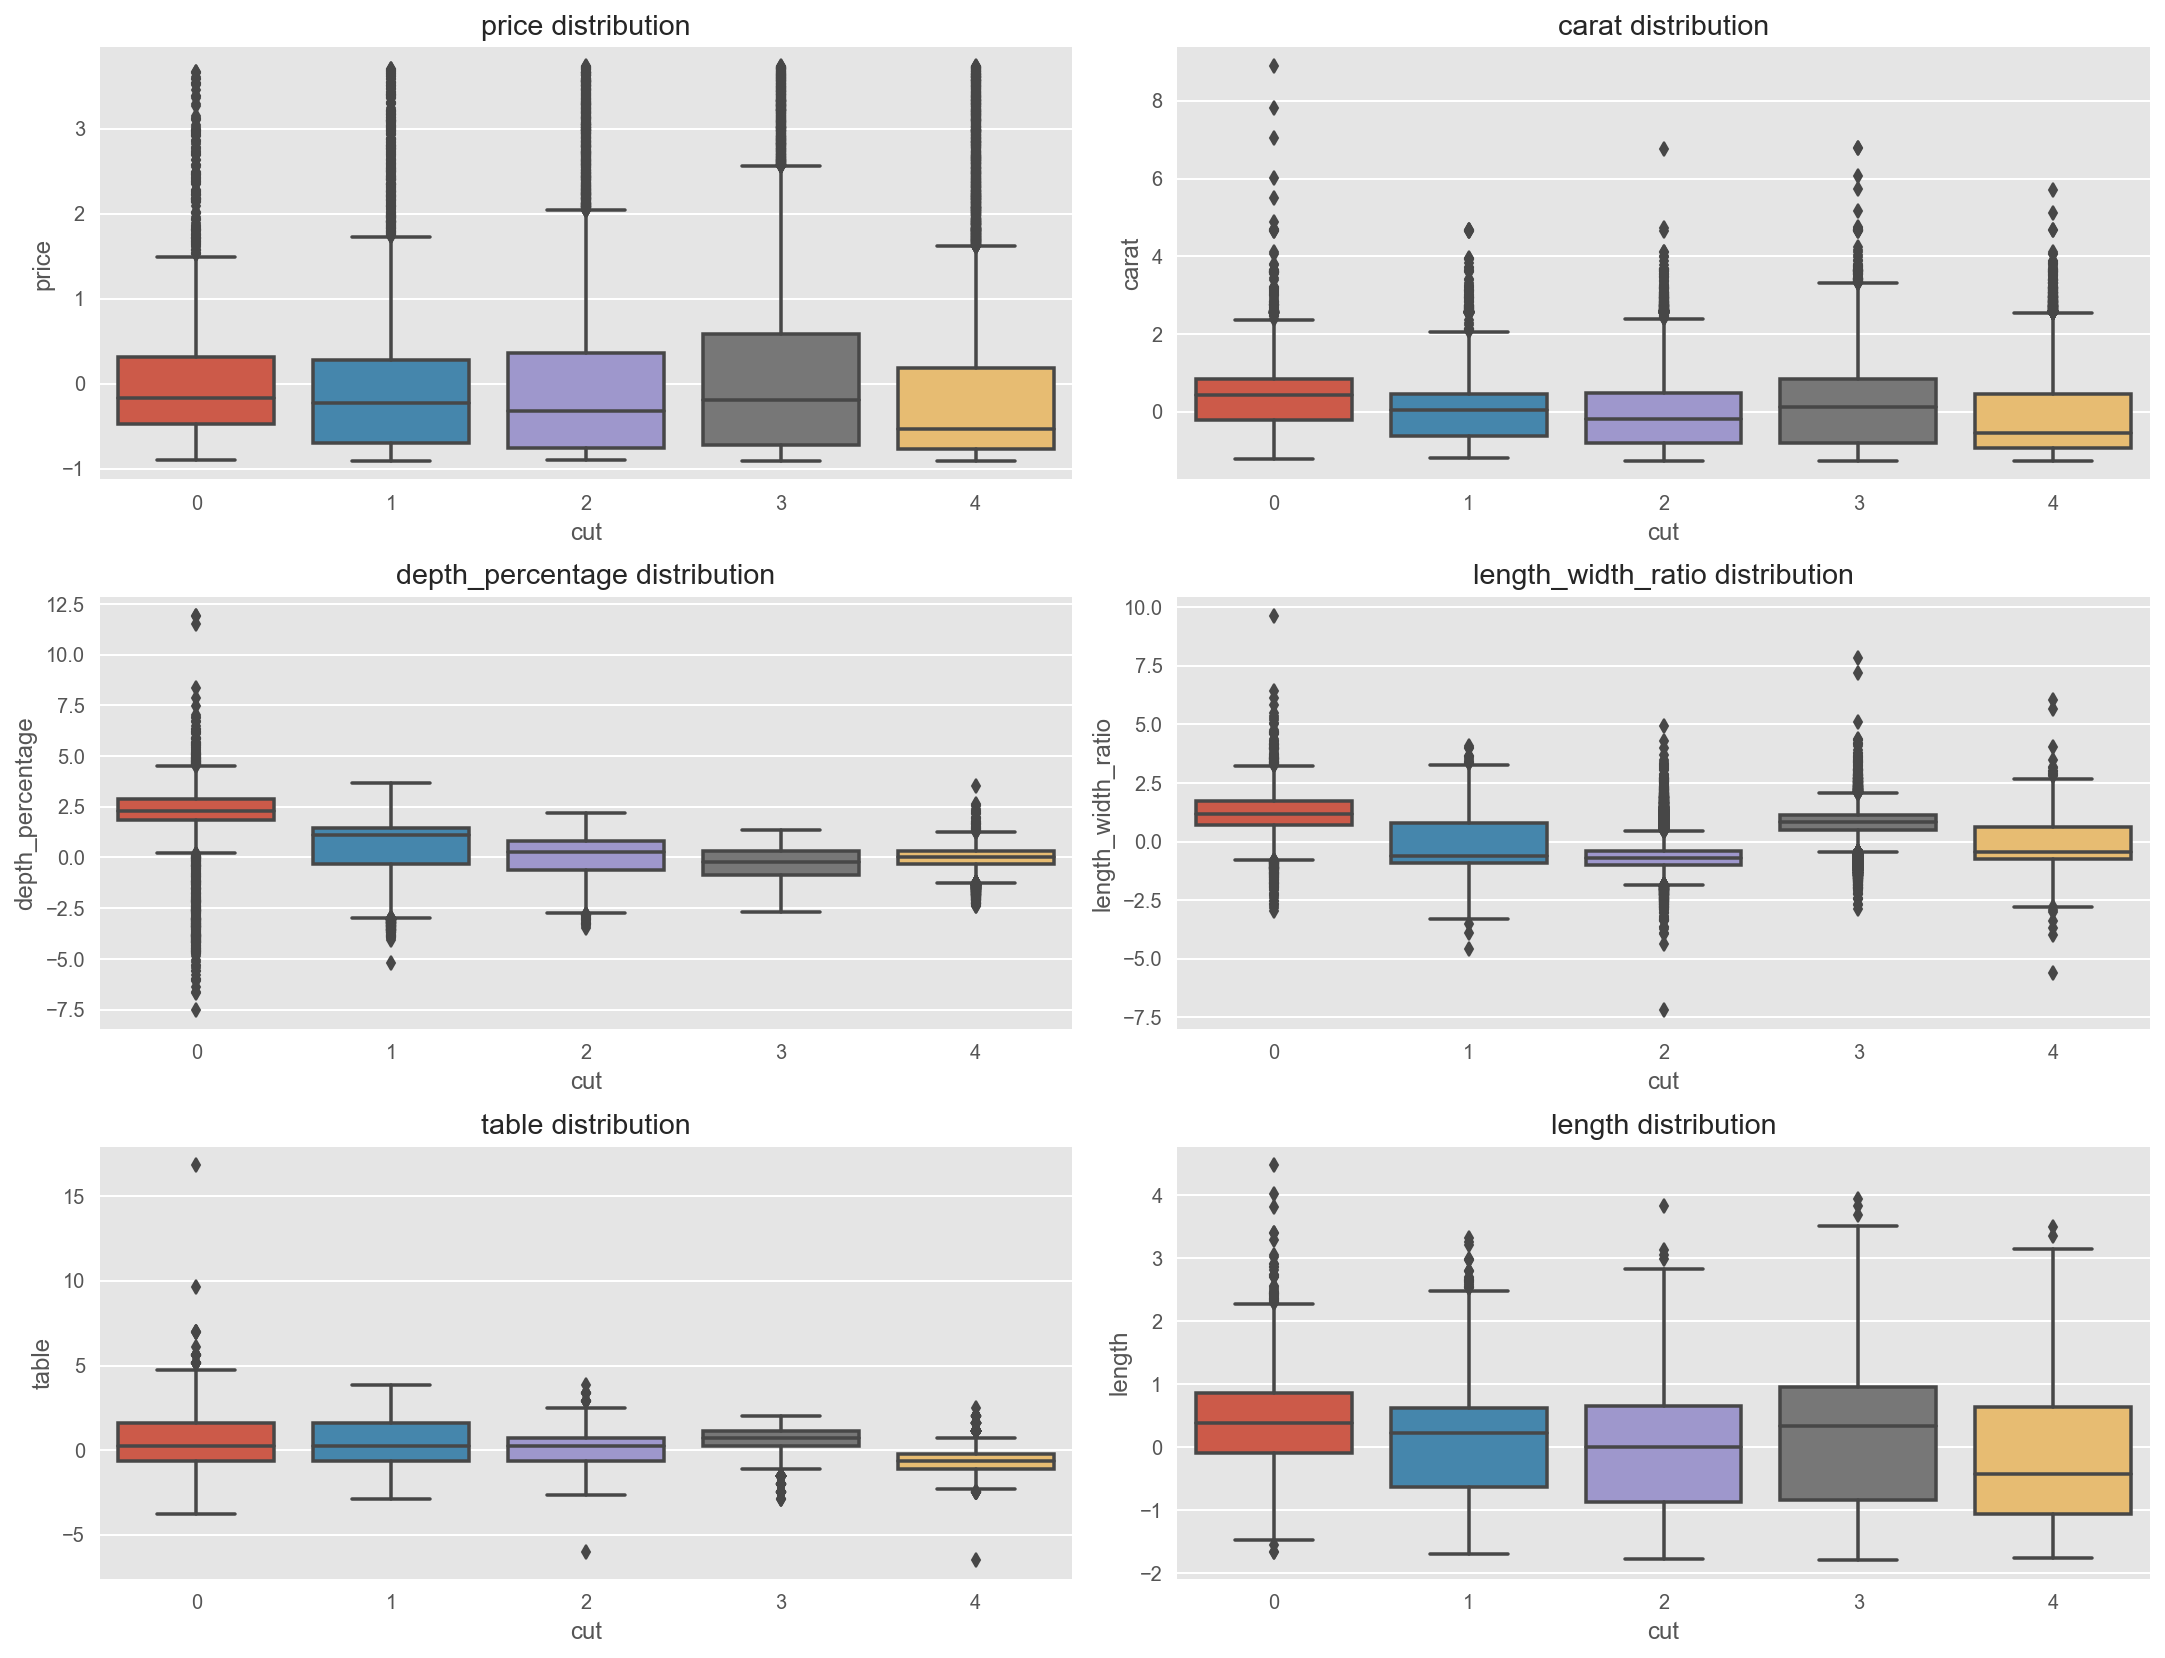

In [29]:
numeric = ['price', 'carat', 'depth_percentage', 'length_width_ratio', 'table', 'length']

# define a figure to which we will add histogram of each attribute.
plt.figure(figsize=(15,15))

#use an index to identify the spot of the subplot
j = 1

# Columns
for k in numeric: #for each numeric column in the dataframe
    plt.subplot(4,2,j)
    sns.boxplot(x="cut", y=k, data=full)
    plt.title(k + " distribution");
    j = j + 1 #add 1 to go to the next subplot space

#show results
plt.tight_layout()
plt.show();

We can see here that the standardization process was successful. Now we can move on the next section safely as all the features are on the similar scale. We can see that depth_percentage, length_width_ratio and table look as promising features to predict the response.

Now we check the categorical features, which are color and clarity, vs the response.

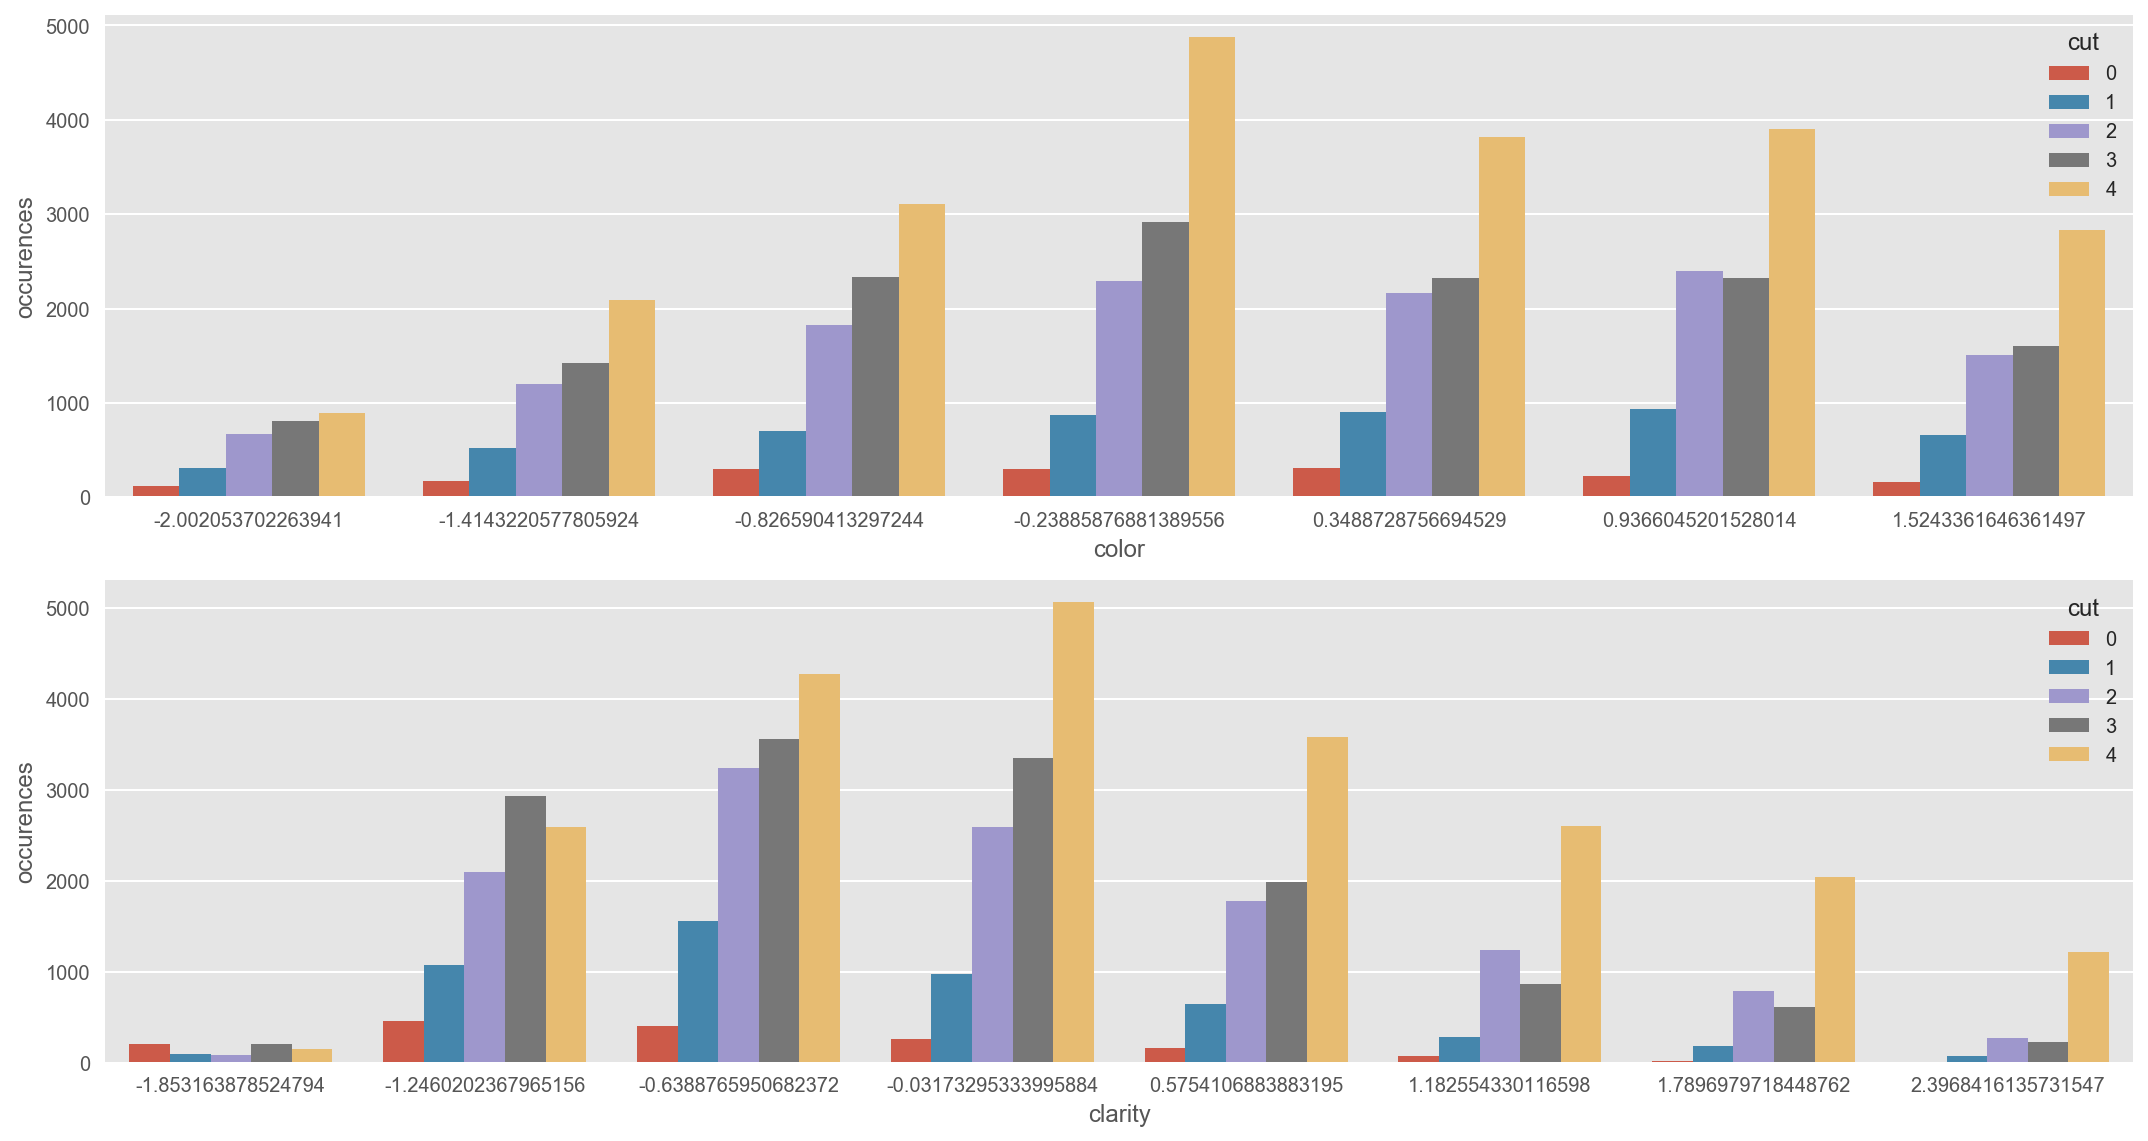

In [30]:
categorical = ['color', 'clarity']

#define a figure to which we will add histogram of each attribute.
plt.figure(figsize=(15,8))

#use an index to identify the spot of the subplot
j = 1

order=[]

# Columns
for k in catergorical: #for each numeric column in the dataframe
    plt.subplot(2,1,j)
    dt = full.groupby([k,'cut']).size().to_frame('occurences').reset_index().sort_values(by='cut', ascending=False)
    sns.barplot(x=k, y='occurences', hue='cut', data=dt)
    j = j + 1 #add 1 to go to the next subplot space

#show results
plt.tight_layout()
plt.show();

We can see here that the standardization process was successful for the categorical ordinal. We also see that the pattern looks to be consistent on the response with each category on both attributes, suggesting that none of these features look to be as predictive as the numeric ones.
Now we can move on the next section safely as all the features are on the similar scale.

# Feature selection
### Recursive feature elimination (RFE) with random forest.


RFE uses a classification method (i.e random forest), to assign weights to each of features. The attributes whose absolute weights are the smallest are pruned from the current set of features. That procedure is recursively repeated on the pruned data set until we get the desired number of features.<br><br>
The reason we chose random forest is because it is a tree based algorithm so we won't have to worry about treating the categorical variables and the numerical variables differently and we can simply feed all of them into our random forest classifier. Another reason we chose random forest is that it has been proven empirically by researchers to provide good results for both linear and nonlinear relationships between predictors. However, the presence of highly correlated predictors has been shown to negatively impact its ability to identify strong predictors which is why we manually removed highly collinear variables earlier in the study.

In [31]:
# Splitting into predictors and response.
# -------------------------------------
X = full.loc[:, full.columns != 'cut']
y = full.loc[:, 'cut']

# set the RF classifier and get the top 4 predictive features
rf_clf = RandomForestClassifier(n_jobs = -1)      
rfe = RFE(estimator=rf_clf, n_features_to_select = 4, step = 1)
rfe = rfe.fit(X, y)
print('Chosen best 4 feature by rfe:',X.columns[rfe.support_])

Chosen best 4 feature by rfe: Index(['depth_percentage', 'table', 'price', 'length_width_ratio'], dtype='object')


Based on our RFE and our domain knowledge, we will choose these four features going forward. <br>
- Depth percentage
- Table
- Price
- length_width_ratio

In [32]:
predictors = list(X.columns[rfe.support_])
predictors 

['depth_percentage', 'table', 'price', 'length_width_ratio']

# Neural Network Modeling

To start we split the data into training and testing sets, using “stratify” as one of the parameters to ensure that all response classification labels are proportionally represented in our training and testing subsets.

For all the models we will have lists to store the metrics for testing set, and we will use an empirical process to select the best hyperparameters based on our analysis for each one. We will use the lists with the corresponding metrics in the model selection section.

In [37]:
#defining the scorers
f1_scorer = metrics.make_scorer(metrics.f1_score, average = 'macro')
precision_scorer = metrics.make_scorer(metrics.precision_score, average = 'macro')
recall_scorer = metrics.make_scorer(metrics.recall_score, average = 'macro')
accuracy_scorer = metrics.make_scorer(metrics.accuracy_score, average = 'macro')

# Lists to store the evaluation metrics
recall_list = []
f1_list = []
precision_list = []
accuracy_list = []

# defining explanatory and response
X = full[predictors]
y = full['cut']

# Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size = 0.2, random_state = 0, stratify=y)

## Neural Network 1

- __Loss function:__ We use sparse_categorical_crossentropy since for each instance we have class target index, from 0 to 5 (exclusive) and we have sparse categories. sparse_categorical_crossentropy is a loss function that seeks to minimize the distance between the probability provided by the soft max and if the response is of that class (0/1).
- __Optimizer:__ The parameter "sgd" means Stochastic Gradient Descent. We use this as the method for optimizing our model or backpropagating it. For more information on Stochastic Gradient Descent please refer to HOML pg. 126 [1]
- __Epochs:__  training The number of iterations we impose upon an ANN, in this case we selected 100 to allow for a sufficient amount of iterations for the model to learn while balancing the cost of computation and time.
- __validation_split:__ we specify 0.1 to allow Keras to use 10% of the training data for validation at the end of each epoch.

__Hyperparameters:__
- __Learning rate:__ when using SGD optimizer is important to tune the learning rate, which by default is 0.01. The learning rate determines the step size at each iteration while moving toward a minimum of a loss function. We prefer the default rate for this model since we are training shallow models and we can afford to use a small learning rate given the relative size of the networks we are creating. 
- __number of layers:__ We will tune this hyperparameter through experimentation by starting with 2 layers in this model and in the final model we will add more layers to see if it improves performance. 
- __number of neurons per layer:__ We begin with 300 and 100 neurons respectively for each layer as our first attempt to train this model. With such a high number of parameters we run the risk of this model overfitting the data and we will pare down the number of neurons in our next ANN to see if this is the case. We choose these numbers as they are very large and we will want to compare their performance with a smaller number of nodes. Since the scope of this study is only four networks we will use these extremes to pick a method. 
[How to configure # layers and nodes](https://machinelearningmastery.com/how-to-configure-the-number-of-layers-and-nodes-in-a-neural-network/)
- __activation function__:
    - ReLU or Rectified Linear Unit function: We chose this activation function because it is not computationally expensive and has been shown empirically to work well. Empirically we know that since this network is small we will not see performance gains by incorporating variants of the ReLU function and we can stick to the basic version of it.  
    - Softmax: The Softmax function is the preferred method for a multinomial classifier. It takes the outputs of the hidden layers of the network and returns to us the probability that a record belongs to all of the classes in our response. In our study there are 5 classes in the response so when we apply the Softmax function we are returned the class with the highest probability associated with it as our prediction.

In [49]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report

In [86]:
model_1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=X_train.shape[1:]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(5, activation="softmax") #output layer with 5 neurons (1 per class)
])

In [87]:
model_1.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd", #using default learning rate 0.01
              
              metrics=["accuracy"])

In [98]:
history = model_1.fit(X_train, y_train, epochs=100,
                    validation_split=0.1);

Epoch 1/100
1212/1212 [==============================] - 1s 1ms/step - loss: 0.5195 - accuracy: 0.7928 - val_loss: 0.5031 - val_accuracy: 0.8094
Epoch 2/100
1212/1212 [==============================] - 3s 2ms/step - loss: 0.5197 - accuracy: 0.7924 - val_loss: 0.5155 - val_accuracy: 0.7987
Epoch 3/100
1212/1212 [==============================] - 3s 2ms/step - loss: 0.5195 - accuracy: 0.7934 - val_loss: 0.5064 - val_accuracy: 0.7936
Epoch 4/100
1212/1212 [==============================] - 2s 1ms/step - loss: 0.5189 - accuracy: 0.7943 - val_loss: 0.5036 - val_accuracy: 0.8004
Epoch 5/100
1212/1212 [==============================] - 2s 1ms/step - loss: 0.5190 - accuracy: 0.7945 - val_loss: 0.5034 - val_accuracy: 0.8066
Epoch 6/100
1212/1212 [==============================] - 2s 2ms/step - loss: 0.5182 - accuracy: 0.7926 - val_loss: 0.5059 - val_accuracy: 0.8039
Epoch 7/100
1212/1212 [==============================] - 2s 1ms/step - loss: 0.5181 - accuracy: 0.7933 - val_loss: 0.5045 - val_ac

Seems like we didn't gain anything by running through the Epochs in this model and that the val_accuracy was stable all the way through

In [118]:
from sklearn.metrics import classification_report

y_pred = model_1.predict(X_test, batch_size=32, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_bool))

169/169 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.95      0.76      0.85       319
           1       0.70      0.80      0.75       980
           2       0.64      0.61      0.62      2415
           3       0.88      0.72      0.79      2748
           4       0.82      0.92      0.87      4306

    accuracy                           0.78     10768
   macro avg       0.80      0.76      0.78     10768
weighted avg       0.79      0.78      0.78     10768



In [119]:
model_1.evaluate(X_test, y_test)

337/337 [==============================] - 0s 834us/step - loss: 0.5301 - accuracy: 0.7849


[0.5300694108009338, 0.7849182486534119]

In [99]:
recall_testing = []
f1_testing = []
precision_testing = []
accuracy_testing = []

In [100]:
#store results
y_pred = model_1.predict(X_test, batch_size=32, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)


precision_testing.append(np.mean(metrics.precision_score(y_test, y_pred_bool, average = None)))
recall_testing.append(np.mean(metrics.recall_score(y_test, y_pred_bool, average = None)))
f1_testing.append(np.mean(metrics.f1_score(y_test, y_pred_bool, average = None)))
accuracy_testing.append(np.mean(metrics.accuracy_score(y_test, y_pred_bool)))

337/337 [==============================] - 0s 728us/step


## Neural Network 2

- __Loss function:__ We use sparse_categorical_crossentropy since for each instance we have class target index, from 0 to 5 (exclusive) and we have sparse categories. sparse_categorical_crossentropy is a loss function that seeks to minimize the distance between the probability provided by the soft max and if the response is of that class (0/1).
- __Optimizer:__ The Adam optimizer is based on stochastic gradient descent with an advantage of having an adaptive learning rate that has been created specifically for training deep neural networks as it showed extremely promising results but in some cases, the results were worse than stochastic gradient descent, however, in other cases, it did extremely well. This incredible `OpenAI` production uses the squared gradient to scale the learning rate and that makes it unique amongst most algorithms and for this reason we think it worth trying. [Link](https://arxiv.org/pdf/1412.6980.pdf)
- __Epochs:__  training The number of iterations we impose upon an ANN, in this case we selected 100 to allow for a sufficient amount of iterations for the model to learn while balancing the cost of computation and time.
- __validation_split:__ we specify 0.1 to allow Keras to use 10% of the training data for validation at the end of each epoch.

__Hyperparameters:__
- __Learning rate:__ when using Adam optimizer is important to tune the learning rate. The learning rate determines the step size at each iteration while moving toward a minimum of a loss function. We prefer a small rate for this model since we are training shallow models and we can afford to use a small learning rate given the relative size of the networks we are creating. We will use a learning rate of 0.002. 
- __number of layers:__ We will tune this hyperparameter experimentally with 2 layers in this model and in the final model we will add more layers to see if it improves performance. 
- __number of neurons per layer:__ We begin with 22 and 12 neurons respectively for each layer to train this model. In the previous model we used a large number of neurons so we seek to use the opposite extreme with a smaller number of neurons per layer. We choose these numbers as they are relatively small and we will want to compare their performance with the larger number of nodes.  
[How to configure # layers and nodes](https://machinelearningmastery.com/how-to-configure-the-number-of-layers-and-nodes-in-a-neural-network/)
- __activation function__:
    - ReLU or Rectified Linear Unit function: We chose this activation function because it is not computationally expensive and has been shown empirically to work well. Empirically we know that since this network is small we will not see performance gains by incorporating variants of the ReLU function and we can stick to the basic version of it.  
    - Softmax: The Softmax function is the preferred method for a multinomial classifier. It takes the outputs of the hidden layers of the network and returns to us the probability that a record belongs to all of the classes in our response. In our study there are 5 classes in the response so when we apply the Softmax function we are returned the class with the highest probability associated with it as our prediction.

In [101]:
model_2 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=X_train.shape[1:]),
    keras.layers.Dense(22, activation="relu"),
    keras.layers.Dense(12, activation="relu"),    
    keras.layers.Dense(5, activation="softmax") #output layer with 5 neurons (1 per class)
])

In [102]:
model_2.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
              metrics=["accuracy"])

In [103]:
history = model_2.fit(X_train, y_train, epochs=100,
                    validation_split=0.1);

Epoch 1/100
1212/1212 [==============================] - 2s 1ms/step - loss: 0.7933 - accuracy: 0.7041 - val_loss: 0.6325 - val_accuracy: 0.7679
Epoch 2/100
1212/1212 [==============================] - 1s 1ms/step - loss: 0.6380 - accuracy: 0.7558 - val_loss: 0.5920 - val_accuracy: 0.7739
Epoch 3/100
1212/1212 [==============================] - 2s 1ms/step - loss: 0.6111 - accuracy: 0.7633 - val_loss: 0.5776 - val_accuracy: 0.7830
Epoch 4/100
1212/1212 [==============================] - 2s 2ms/step - loss: 0.5972 - accuracy: 0.7679 - val_loss: 0.5703 - val_accuracy: 0.7797
Epoch 5/100
1212/1212 [==============================] - 3s 2ms/step - loss: 0.5885 - accuracy: 0.7717 - val_loss: 0.5577 - val_accuracy: 0.7853
Epoch 6/100
1212/1212 [==============================] - 2s 1ms/step - loss: 0.5826 - accuracy: 0.7735 - val_loss: 0.5476 - val_accuracy: 0.7864
Epoch 7/100
1212/1212 [==============================] - 2s 1ms/step - loss: 0.5772 - accuracy: 0.7729 - val_loss: 0.5457 - val_ac

Gains from backprop peaked around 25 Epochs, and we moved from 76.7% accuracy to 80.5%

In [75]:
# create classification report
y_pred = model_2.predict(X_test, batch_size=32, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_bool))

337/337 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.92      0.82      0.86       319
           1       0.76      0.64      0.70       980
           2       0.63      0.64      0.63      2415
           3       0.86      0.75      0.80      2748
           4       0.82      0.92      0.87      4306

    accuracy                           0.78     10768
   macro avg       0.80      0.75      0.77     10768
weighted avg       0.78      0.78      0.78     10768



In [104]:
#store results
y_pred = model_2.predict(X_test, batch_size=32, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)


precision_testing.append(np.mean(metrics.precision_score(y_test, y_pred_bool, average = None)))
recall_testing.append(np.mean(metrics.recall_score(y_test, y_pred_bool, average = None)))
f1_testing.append(np.mean(metrics.f1_score(y_test, y_pred_bool, average = None)))
accuracy_testing.append(np.mean(metrics.accuracy_score(y_test, y_pred_bool)))

337/337 [==============================] - 0s 737us/step


### Neural Network 3

__Changes:__ In this model we seek to build off  model 2 and see if we can achieve a higher performing model with all of the __classes being balanced__.

All hyperparameters in this model will be the same as model 2.

In [108]:
#using class weigths
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weight = {0: class_weights[0],
                1: class_weights[1],
                2: class_weights[2],
                3: class_weights[3],
                4: class_weights[4]}

In [109]:
class_weight

{0: 6.756392156862745,
 1: 2.1969905636317266,
 2: 0.8916675292412793,
 3: 0.7838398544131028,
 4: 0.5001103047895501}

In [110]:
model_3 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=X_train.shape[1:]),
    keras.layers.Dense(22, activation="relu"),
    keras.layers.Dense(12, activation="relu"),
    keras.layers.Dense(5, activation="softmax") #output layer with 5 neurons (1 per class)
])

In [112]:
model_3.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
              metrics=["accuracy"])

In [113]:
history = model_3.fit(X_train, y_train, epochs=100,
                    validation_split=0.1,
                     class_weight = class_weight);

Epoch 1/100
1212/1212 [==============================] - 1s 1ms/step - loss: 0.9035 - accuracy: 0.6618 - val_loss: 0.6867 - val_accuracy: 0.7484
Epoch 2/100
1212/1212 [==============================] - 1s 1ms/step - loss: 0.6689 - accuracy: 0.7333 - val_loss: 0.6327 - val_accuracy: 0.7600
Epoch 3/100
1212/1212 [==============================] - 1s 1ms/step - loss: 0.6412 - accuracy: 0.7423 - val_loss: 0.6226 - val_accuracy: 0.7665
Epoch 4/100
1212/1212 [==============================] - 1s 1ms/step - loss: 0.6256 - accuracy: 0.7489 - val_loss: 0.6106 - val_accuracy: 0.7662
Epoch 5/100
1212/1212 [==============================] - 1s 1ms/step - loss: 0.6109 - accuracy: 0.7508 - val_loss: 0.6069 - val_accuracy: 0.7674
Epoch 6/100
1212/1212 [==============================] - 1s 1ms/step - loss: 0.6060 - accuracy: 0.7523 - val_loss: 0.6024 - val_accuracy: 0.7639
Epoch 7/100
1212/1212 [==============================] - 1s 1ms/step - loss: 0.5966 - accuracy: 0.7540 - val_loss: 0.6027 - val_ac

Gains from backprop peaked around 39 Epochs, and we moved from 74.8% accuracy to 79.0%

In [114]:
y_pred = model_3.predict(X_test, batch_size=32, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_bool))

337/337 [==============================] - 0s 744us/step
              precision    recall  f1-score   support

           0       0.76      0.93      0.84       319
           1       0.69      0.77      0.73       980
           2       0.60      0.63      0.61      2415
           3       0.88      0.72      0.79      2748
           4       0.84      0.87      0.86      4306

    accuracy                           0.77     10768
   macro avg       0.75      0.78      0.77     10768
weighted avg       0.78      0.77      0.77     10768



In [115]:
#store results
y_pred = model_3.predict(X_test, batch_size=32, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)


precision_testing.append(np.mean(metrics.precision_score(y_test, y_pred_bool, average = None)))
recall_testing.append(np.mean(metrics.recall_score(y_test, y_pred_bool, average = None)))
f1_testing.append(np.mean(metrics.f1_score(y_test, y_pred_bool, average = None)))
accuracy_testing.append(np.mean(metrics.accuracy_score(y_test, y_pred_bool)))

337/337 [==============================] - 0s 722us/step


### Neural Network 4

__Changes:__ In this model we seek to build off model 2 and see if we can achieve a higher performing model by changing the __number of layers__ in the model.

All other hyperparameters in this model will be the same as model 2.


- __number of layers:__ We began with 2 layers in model 2 we will now add more layers to see if it improves performance. We will have 4 layers in this model. 
- __number of neurons per layer:__ We began with 22 and 12 neurons respectively for each layer in model 2. We saw that this outperformed the model with large number of nodes. Because of this we will prefer a smaller number of nodes in the layers that we add to this model. For layers 3 and 4 respectively we will assign 24 and 8 neurons. We choose these numbers as they are relatively similar in size and proportion to layers 1 and 2 and we will want to compare their performance with the smaller number of layers.  
[How to configure # layers and nodes](https://machinelearningmastery.com/how-to-configure-the-number-of-layers-and-nodes-in-a-neural-network/)

In [116]:
model_4 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=X_train.shape[1:]),
    keras.layers.Dense(22, activation="relu"),
    keras.layers.Dense(12, activation="relu"),
    keras.layers.Dense(24, activation="relu"),
    keras.layers.Dense(8, activation="relu"),
    keras.layers.Dense(5, activation="softmax") #output layer with 5 neurons (1 per class)
])

In [117]:
model_4.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
              metrics=["accuracy"])

In [118]:
history = model_4.fit(X_train, y_train, epochs=100,
                    validation_split=0.1);

Epoch 1/100
1212/1212 [==============================] - 1s 1ms/step - loss: 0.7328 - accuracy: 0.7128 - val_loss: 0.5883 - val_accuracy: 0.7693
Epoch 2/100
1212/1212 [==============================] - 1s 1ms/step - loss: 0.5914 - accuracy: 0.7670 - val_loss: 0.5581 - val_accuracy: 0.7746
Epoch 3/100
1212/1212 [==============================] - 1s 1ms/step - loss: 0.5765 - accuracy: 0.7701 - val_loss: 0.5424 - val_accuracy: 0.7916
Epoch 4/100
1212/1212 [==============================] - 1s 1ms/step - loss: 0.5675 - accuracy: 0.7727 - val_loss: 0.5392 - val_accuracy: 0.7895
Epoch 5/100
1212/1212 [==============================] - 1s 1ms/step - loss: 0.5618 - accuracy: 0.7761 - val_loss: 0.5414 - val_accuracy: 0.7876
Epoch 6/100
1212/1212 [==============================] - 1s 1ms/step - loss: 0.5588 - accuracy: 0.7747 - val_loss: 0.5444 - val_accuracy: 0.7816
Epoch 7/100
1212/1212 [==============================] - 1s 1ms/step - loss: 0.5534 - accuracy: 0.7767 - val_loss: 0.5324 - val_ac

Gains from backprop peaked around 20 Epochs, and went from 76.9% accuracy to 80.8%

In [121]:
# create classification report
y_pred = model_4.predict(X_test, batch_size=32, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)


print(classification_report(y_test, y_pred_bool))

337/337 [==============================] - 0s 858us/step
              precision    recall  f1-score   support

           0       0.89      0.87      0.88       319
           1       0.73      0.76      0.74       980
           2       0.66      0.60      0.63      2415
           3       0.85      0.77      0.81      2748
           4       0.83      0.91      0.87      4306

    accuracy                           0.79     10768
   macro avg       0.79      0.78      0.79     10768
weighted avg       0.79      0.79      0.79     10768



In [122]:
#store results
y_pred = model_4.predict(X_test, batch_size=32, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

precision_testing.append(np.mean(metrics.precision_score(y_test, y_pred_bool, average = None)))
recall_testing.append(np.mean(metrics.recall_score(y_test, y_pred_bool, average = None)))
f1_testing.append(np.mean(metrics.f1_score(y_test, y_pred_bool, average = None)))
accuracy_testing.append(np.mean(metrics.accuracy_score(y_test, y_pred_bool)))

337/337 [==============================] - 0s 647us/step


# Model Selection
In this section we look closer at the metrics we collected and compare them in a table.

In [126]:
validation_accuracy = []
validation_accuracy.append('0.8087')
validation_accuracy.append('0.8050')
validation_accuracy.append('0.7869')
validation_accuracy.append('0.8083')

metrics_summary_training = pd.DataFrame()
metrics_summary_training['Model #'] = ['Network_1', 'Network_2', 'Network_3',
                                       'Network_4']
metrics_summary_training['Predictors'] = [4,4,4,4]
metrics_summary_training['Validation Accuracy'] = validation_accuracy
metrics_summary_training

,Model #,Predictors,Validation Accuracy
0,Network_1,4,0.8087
1,Network_2,4,0.8050
2,Network_3,4,0.7869
3,Network_4,4,0.8083


We see that Network 1 has the best accuracy though it is very close to models 2 and 4. We now look to see the metrics from test data metrics.

In [123]:
metrics_summary_testing = pd.DataFrame()
metrics_summary_testing['Model #'] = ['Network_1', 'Network_2', 'Network_3',
                                       'Network_4']
metrics_summary_testing['Predictors'] = [4,4,4,4]
metrics_summary_testing['Recall'] = recall_testing
metrics_summary_testing['Precision'] = precision_testing
metrics_summary_testing['F1_score'] = f1_testing
metrics_summary_testing['Accuracy_score'] = accuracy_testing

metrics_summary_testing

,Model #,Predictors,Recall,Precision,F1_score,Accuracy_score
0,Network_1,4,0.761585,0.801491,0.779187,0.787147
1,Network_2,4,0.765450,0.777489,0.769605,0.784918
2,Network_3,4,0.784894,0.753546,0.765494,0.772288
3,Network_4,4,0.782490,0.791036,0.785610,0.791326


Even though Model 1 has the highest performance for Precision it does not have competitive scores for the other metrics. Additionally, it is very computationally expensive as it has 300 neurons in the first layer and 100 neurons in the second layer of the network.

We see that model 4 outperforms every model except in every metric except for Network 1 in Precision.<br>
However since the model 4 outperforms Network 1 in all other categories we prefer it over network one.

# Conclusions

- This data had a blend of both categorical and numerical data. In our feature selection process we choose to make use of `Domain Knowledge`, `EDA` and use a wrapper feature selection method called `RFE`. We used ` RFE` via `Random forests` to rank our features from best to worst and from then we chose from the top features what we believe would be predictive based on our domain knowledge. It is also important to mention that the reason we chose random forest is because random forest works well with both categorical and numerical data.

- Our response variable for this dataset was ordinal categorical, with two categories(Fair, Good) being ill-represented and for this reason we paid special attention to how we evaluate it, by emphasizing metrics such as `F1`,`Recall` and `precision` over other metrics.

- Model 4 outperforms all other models except for Network 1 for the metric of Precision (and the difference is very small). 

- For all of our model building we considered different hyper-parameters to try to improve performance and tried different Optimizers, number of neurons, number of layer, and using balanced classes.

- Model selection was very straight forward since model 4 outperformed all of the other models.


# References

https://www.withclarity.com/education/diamond-education/diamond-carat

https://www.serendipitydiamonds.com/blog/how-to-measure-a-diamond/

https://www.withclarity.com/education/diamond-education/diamond-cut/what-is-diamond-depth-or-diamond-education

https://www.bluenile.com/education/diamonds/lengthtowidthratio

https://bmcgenet.biomedcentral.com/articles/10.1186/s12863-018-0633-8

http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html

https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier

https://xgboost.readthedocs.io/en/latest/parameter.html

Hands-On Machine Learning with Scikit-Learn and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems, pg 126 [1]

ibid. pg 321 [2]